# Disclaimer & Copyright

Copyright 2024 : Forusone - shins777@gmail.com

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Gemini - Image analysis and software development with ER-Diagram

* This notebook explains how to use Gemini to understand images in multimodality features of Gemini.  
* Multimodality is one of the core capabilities in the latest foundation models and Gemini models are fundamentally built on this multimodality.
* In this demo, we can understand how to leverage multimodality to improve the productivity of software development.

* ***https://cloud.google.com/vertex-ai/generative-ai/docs/learn/overview***

# Configuration
## Install aiplatform library
* Vertex AI SDK for Python
  * https://cloud.google.com/python/docs/reference/aiplatform/latest
* Vertex AI initialization : aiplatform.init(..)
  * https://cloud.google.com/python/docs/reference/aiplatform/latest#initialization

In [ ]:
%pip install --upgrade --quiet google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Markdown

## Authentication to access to the GCP

* Use OAuth to access the GCP environment.
 * Refer to the authentication methods in GCP : https://cloud.google.com/docs/authentication?hl=ko

In [ ]:
#  For only colab to authenticate to get an access to the GCP.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

## Mount to the google drive to access the .ipynb files in the repository.


In [ ]:
# To access contents in Google drive

if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Image location
* https://stackoverflow.com/questions/74717486/clarity-on-erd-diagram
* Don't use the following image for other purpose.

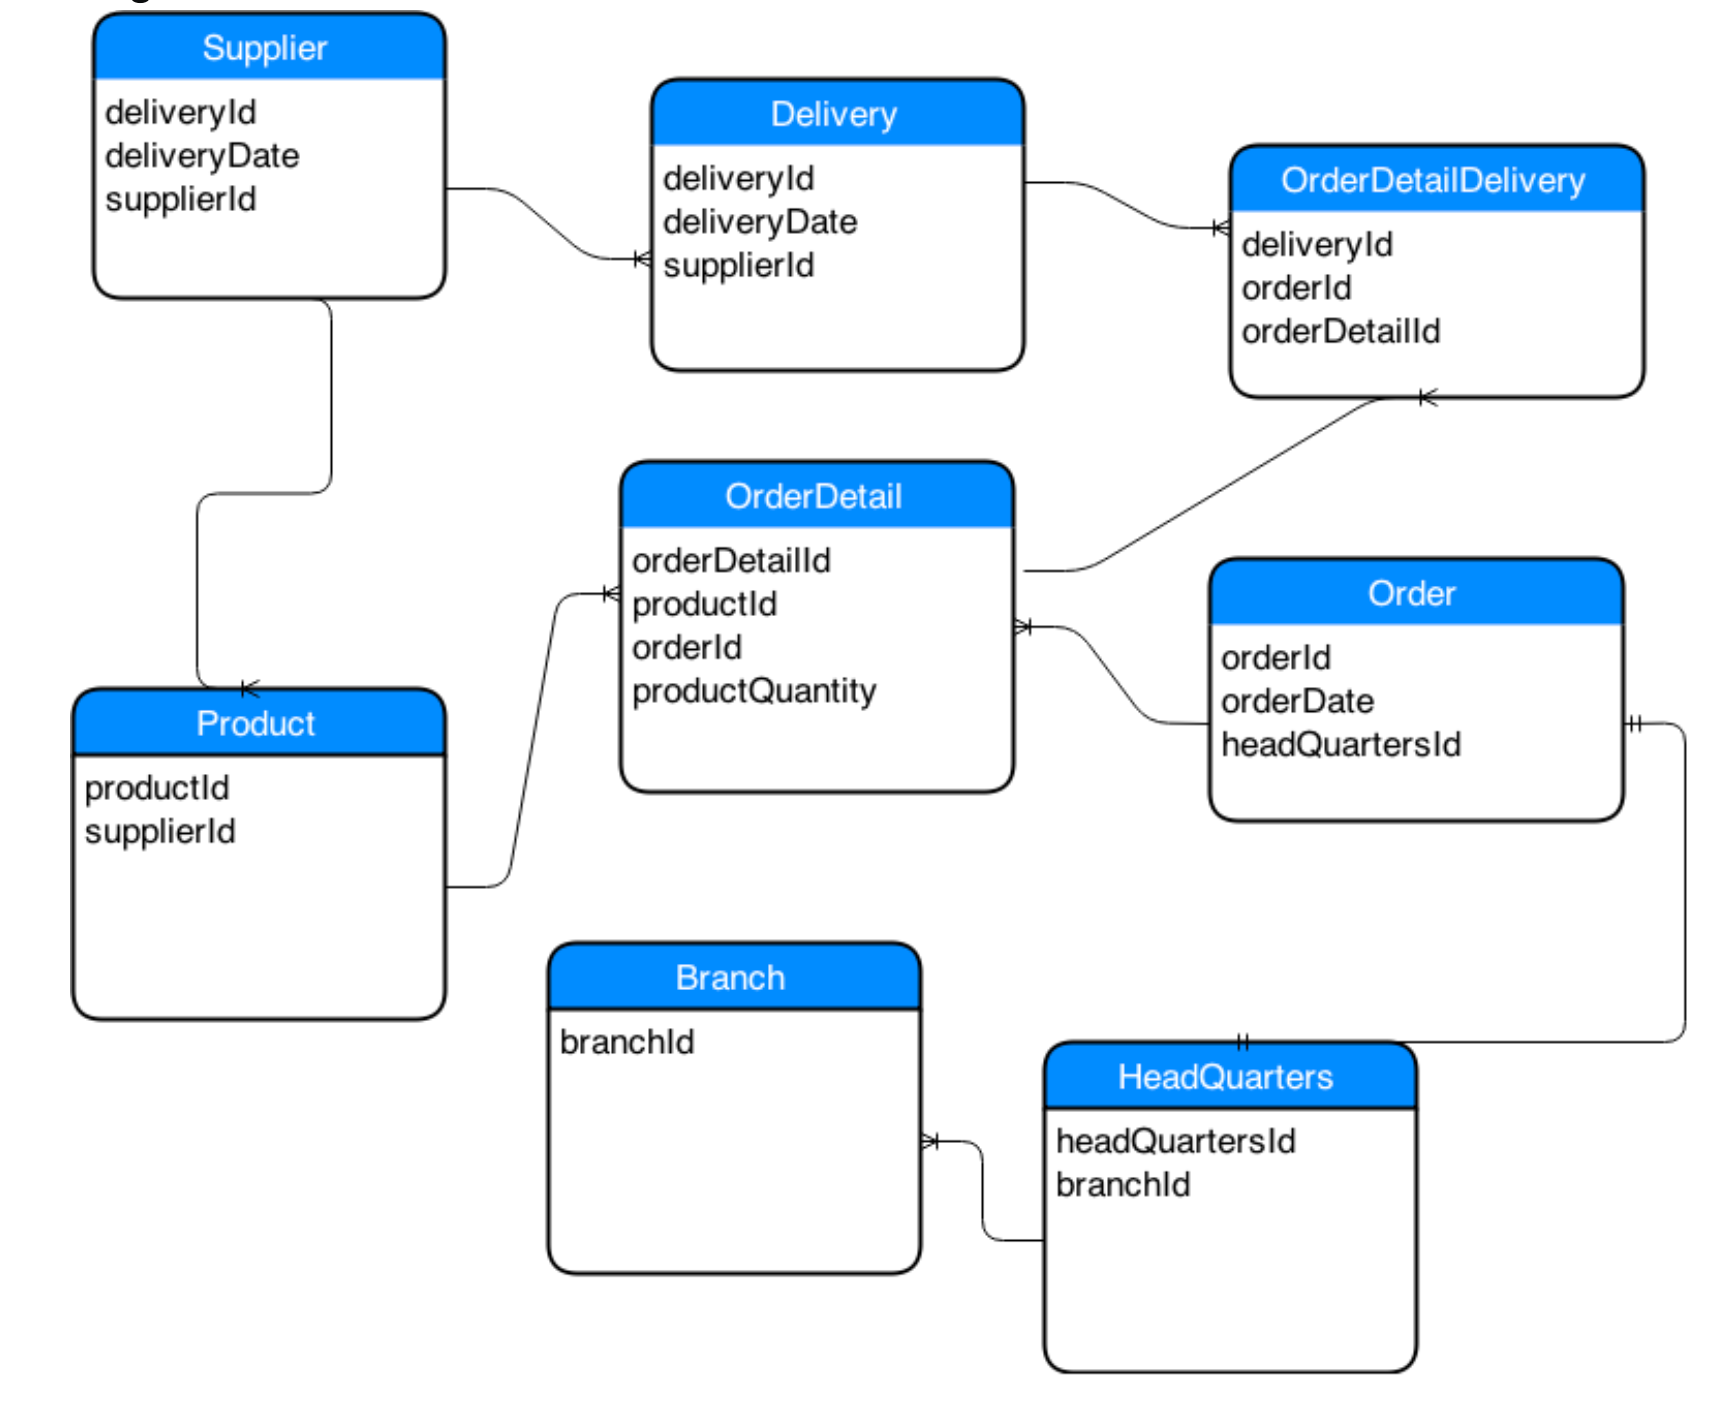

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/projects/google_gen_ai_sample/contents/images/ER-diagram.png', width=800, height=700)

# Run the example
## Set the environment on GCP Project
* Configure project information
  * Model name : LLM model name : https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models
  * Project Id : prodect id in GCP
  * Region : region name in GCP

In [ ]:
MODEL_NAME="gemini-1.5-flash"
PROJECT_ID="ai-hangsik"
REGION="asia-northeast3"

## Vertex AI initialization
Configure Vertex AI and access to the foundation model.

In [ ]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models

# Initalizate the current vertex AI execution environment.
vertexai.init(project=PROJECT_ID, location=REGION)

# Access to the generative model.
model = GenerativeModel(MODEL_NAME)

## Encoding function for multimodality

In [ ]:
import base64

def get_encoded_content(location_type, location, mime_type ):
  """
  Get the encoded content object.

  location_type :
    The type of the location. ( local or GCS )
  location :
    The file location of the content.
  mime_type :
    The mime type of the content.

  Returns:
    The encoded content object.

  """

  content_obj = None

  if location_type == "local":
    with open(location, 'rb') as f:
      raw_obj = base64.b64encode(f.read()).decode('utf-8')
      content_obj = Part.from_data(data=base64.b64decode(raw_obj), mime_type=mime_type)

  elif location_type == "GCS":
        content_obj = Part.from_uri(location, mime_type=mime_type)
  else:
    raise ValueError("Invalid location type.")

  return content_obj


## Get responses from Gemini

In [ ]:

def generate(content_obj, query:str):
    """
    Generate a response from the model.

    content_obj :
      encoded object being analyzed in the process
    query :
      query to be sent to the model

    Returns:
      The generated response.

    """

    # Set model parameter : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts#set_model_parameters
    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    # Configure satey setting : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes
    # Refer to the link to remove : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes#how_to_remove_automated_response_blocking_for_select_safety_attributes
    safety_settings = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }

    responses = model.generate_content(
        [content_obj, query],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )

    return responses.text

## Run example

In [ ]:
from time import perf_counter

t1_start = perf_counter()

# When using local storage for the file location.
location_type = "local"
mime_type = "image/png"

repository_root = "/content/drive/MyDrive/projects"
file_path = "/google_gen_ai_sample/contents/images/ER-diagram.png"
location = repository_root + file_path

content_obj = get_encoded_content(location_type, location, mime_type )

prompt = """You are an AI assistant helping software development.
Write down python code in the following instruction.

1. Refer to the ERD to write a code.
2. Get the information order id, product id, delivery id, payment id and head quarters id by product id.
3. Retrieve the result from joining tables in the ERD.

"""

outcome = generate(content_obj, prompt)

t1_end  = perf_counter()
print(f"Time : {t1_end - t1_start} seconds\n\n")

display(Markdown(outcome))


# When using Google Cloud Storage for the location type.

# location_type = "GCS"
# mime_type = "image/jpeg"
# repository_root = "gs://bucket_name"
# file_path = "/ERD.jpeg"
# location = repository_root + file_path


Time : 7.054969685999993 seconds




```python
import sqlite3
conn = sqlite3.connect('mydatabase.db')
cursor = conn.cursor()

def get_order_info_by_product_id(product_id):
    """
    Retrieves order information by product ID, including order ID, product ID, delivery ID, payment ID, and head quarters ID.

    Args:
        product_id: The ID of the product.

    Returns:
        A list of tuples containing the order information, or an empty list if no matching orders are found.
    """

    query = """
        SELECT 
            O.orderId, 
            OD.productId,
            D.deliveryId,
            HQ.headQuartersId
        FROM Order AS O
        JOIN OrderDetail AS OD ON O.orderId = OD.orderId
        JOIN Delivery AS D ON O.orderId = D.orderId
        JOIN HeadQuarters AS HQ ON O.headQuartersId = HQ.headQuartersId
        WHERE OD.productId = ?
    """
    cursor.execute(query, (product_id,))
    result = cursor.fetchall()
    return result

# Example usage
product_id = 123  # Replace with the desired product ID
order_info = get_order_info_by_product_id(product_id)

if order_info:
    print("Order Information for Product ID", product_id, ":")
    for row in order_info:
        print("Order ID:", row[0])
        print("Product ID:", row[1])
        print("Delivery ID:", row[2])
        print("Head Quarters ID:", row[3])
        print("-" * 20)
else:
    print("No orders found for product ID", product_id)

conn.close()
```